<a href="https://colab.research.google.com/github/HuangruiChu/MIMIC-III-Breast-Cancer-study/blob/main/MIMIC_Breast_Cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div align='center' ><font size='5'>
BIS 638 (FA22): Clinical Database Management Systems and Ontologies Final Project
</font></div>

<div align='center' ><font size='6'>
Breast Cancer Analysis based on MIMIC III
</font></div>

<div align='center' ><font size='4'>
Group Name: Infinite Justice

Group Member：Huangrui Chu, Yaoqi Li, Laura Sun, Mingrui Wang

Yale Univserity School of Public Health
</font></div>


# **1. Introduction**

*This project for Yale Course BIS 638: Clinical Database Management Systems and Ontologies Final Project*

## 1.1 Background
- **请简介一下 breast cancer**

<br/>

## 1.2 Research Questions
- 放上我们的research question **需要后期再arrange 一下**
1.	Age distribution of breast cancer patients (when visiting hospitals, diagnosed, dead) V.S International organization’s recommendation for women's health check and breast cancer high-occurrence age. 
a.	Time from treatment to death, find the avg/median （**在考虑在第一部分要不要删了）
b.	Age distribution, survival ratio (survived V.S dead) （**我其实是把死亡率，性别比例等等分开来的）
2.	Breast cancer and its complication 
3.	What are the attributes that are most correlated to breast cancer? (Utilizing random forest to rank the feature importance based on Gini parameters)
4.	 Mortality 
a.	Visualize the distribution of the Top 3 variables for all patients in the breast cancer dataset. (Or establish ML (SVM, LR, XGBoost) models to predict in-hospital mortality using the Top 10 essential features if time is enough)
b.	What kind of previous and current services for the breast cancer patient? Do the hospital service's transformation and transfer time affect breast cancer patients' mortality? 
c. Find the correlation between mortality and prescriptions such as drug type, dose, and route. 
5.	Find the correlation between mortality and prescriptions such as drug type, dose, and route. 
<br/>

## 1.3 Data Sources

The data comes from [MIMIC-III](https://physionet.org/content/mimiciii/1.4/), which is a large, freely-available database comprising deidentified health-related data associated with over forty thousand patients who stayed in critical care units of the Beth Israel Deaconess Medical Center between 2001 and 2012. The database includes information such as demographics, vital sign measurements made at the bedside (~1 data point per hour), laboratory test results, procedures, medications, caregiver notes, imaging reports, and mortality (including post-hospital discharge).

MIMIC supports a diverse range of analytic studies spanning epidemiology, clinical decision-rule improvement, and electronic tool development. It is notable for three factors: it is freely available to researchers worldwide; it encompasses a diverse and very large population of ICU patients; and it contains highly granular data, including vital signs, laboratory results, and medications.
  
  
  摘自 abstract 大家可以paraphrase 一下

<div  align="center"> 
<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTeV6ahtZ6-POUjabTbHU973fbwmNAqleU5ag&usqp=CAU" width = "100" alt="img" />
</div>


  - To access MIMIC-III, our group have finished [CITI Training for Data or Specimens Only Research](https://www.citiprogram.org/verify/?wf27bcd4b-1305-43f1-a4f9-16549df886fa-51130798). The certifications are shown below.

<div  align="center"> 

<img src="https://raw.githubusercontent.com/HuangruiChu/MIMIC-III-Breast-Cancer-study/main/CITI_certification_Huangrui_Chu.png" width = "300" alt="img" />
<img src="https://raw.githubusercontent.com/HuangruiChu/MIMIC-III-Breast-Cancer-study/main/CITI_certification_Mingrui_Huang.png" width = "300" alt="img" />
<img src="https://raw.githubusercontent.com/HuangruiChu/MIMIC-III-Breast-Cancer-study/main/CITI_certification_Yaoqi_Li.jpg" width = "300" alt="img" />
<img src="https://raw.githubusercontent.com/HuangruiChu/MIMIC-III-Breast-Cancer-study/main/CITI_certification_Kuankuan_Sun.png" width = "300" alt="img" />
</div>

Data files have be downloaded and saved in google drive, and will be loaded into google colab. The data are for research study only and we would not upload them to github.

<br/>

## 1.4 Methods 
<br/>
<img src="https://mark.trademarkia.com/logo-images/epoint-sa/vertabelo-86225942.jpg" height = "50" alt="img" />
<img src="https://www.sqlite.org/images/sqlite370_banner.gif" height = "50" alt="img" />
<img src="https://miro.medium.com/max/776/1*Lad06lrjlU9UZgSTHUoyfA.png" height = "50" alt="img" />
<img src="https://www.ebi.ac.uk/ols/img/OLS_logo_2017.png" height = "50" alt="img" />

<br/>

#大概也要paraphrase 一下
- Use [Vertabelo Database Modeler](https://vertabelo.com/) to design an ER model, then generate a MySQL script.
- Use google colab to install SQLite, read in SQL script and create a database with MIMIC III data.
- Use [OLS](https://www.ebi.ac.uk/ols/index) as an ontology resource, link the disease terms in Disease Ontology to the patient data representation (icd9_code)





# **2. Database Construction** 

## 2.1 Coding Environment Preparation

- Mount google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


- Require libraries

In [ ]:
import pandas as pd
import sqlite3
from sqlite3 import Error
from IPython.display import display
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats

## 2.2 Data Resource

- The data files we will use include:
  - `PATIENTS`: Defines each SUBJECT_ID in the database, i.e. defines a single patient
  - `ADMISSIONS`: Define a patient’s hospital admission, HADM_ID
  - `DIAGNOSES_ICD`: Contains ICD diagnoses for patients, most notably ICD-9 diagnoses
  - `D_ICD_DIAGNOSES`: Definition table for ICD diagnoses
  - `ICUSTAYS`: Defines each ICUSTAY_ID in the database, i.e. defines a single ICU stay
  - `PRESCRIPTIONS`: Contains medication related order entries, i.e. prescriptions
  - `LABEVENTS`: Contains information regarding laboratory based measurements.

- We Create an ER model with Vertabelo for our project

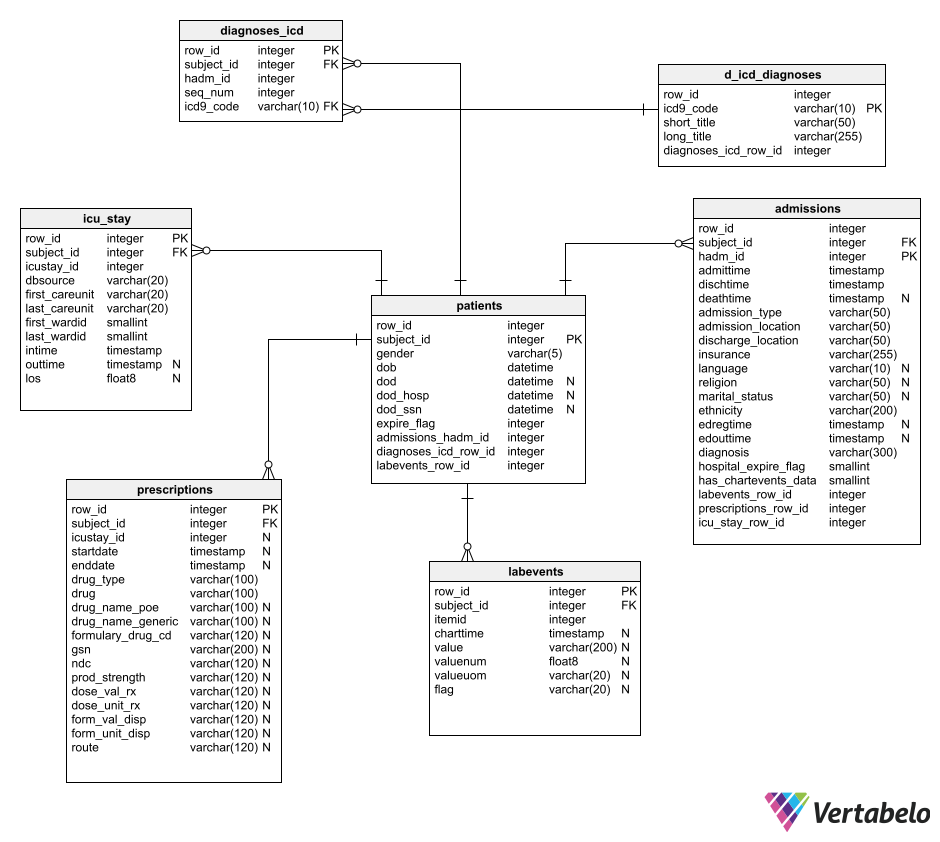

  - The whole MIMIC Schema and Entity-Relationship (ER) Diagram can be seen via this [link](https://mit-lcp.github.io/mimic-schema-spy/)

- Write Python code with embedded SQL to create database, tables and query the tables


In [ ]:
""" create a database connection to a database that resides
    in the drive
"""
conn = None;

#conn = sqlite3.connect(':memory:')
#replace the following file path with your own
conn = sqlite3.connect('/content/gdrive/MyDrive/BIS638/2022/mimic_labdata.db')

cursor = conn.cursor()
#Doping tables if already exists.
cursor.execute("DROP TABLE IF EXISTS Patients")
cursor.execute("DROP TABLE IF EXISTS Admissions")
cursor.execute("DROP TABLE IF EXISTS Diagnoses_icd")
cursor.execute("DROP TABLE IF EXISTS D_icd_diagnoses")
#Creating tables
# The meaning of these variables can be seen here https://mit-lcp.github.io/mimic-schema-spy/tables/patients.html
sql ='''CREATE TABLE Patients (
  row_id int  NOT NULL,
  subject_id int  NOT NULL,
  gender varchar(5)  NOT NULL,
  dob datetime  NOT NULL,
  dod datetime  NOT NULL,
  dod_hosp datetime  NULL,
  dod_ssn datetime  NULL,
  expire_flag varchar(5)  NOT NULL,
  PRIMARY KEY (subject_id)
);'''
cursor.execute(sql)
sql ='''CREATE TABLE Admissions (
  row_id int  NOT NULL,
  subject_id int  NOT NULL,
  hadm_id int  NOT NULL,
  admittime datetime  NOT NULL,
  dischtime datetime  NOT NULL,
  deathtime datetime   NULL,
  admission_type varchar(50)  NOT NULL,
  admission_location varchar(50)  NOT NULL,
  discharge_location varchar(50)  NOT NULL,
  insurance varchar(255)  NOT NULL,
  language varchar(10)   NULL,
  religion varchar(50)   NULL,
  marital_status varchar(50)   NULL,
  ethnicity varchar(200)  NOT NULL,
  edregtime datetime   NULL,
  edouttime datetime   NULL,
  diagnosis varchar(300)  NOT NULL,
  hospital_expire_flag int  NOT NULL,
  has_chartevents_data int  NOT NULL,
  PRIMARY KEY (hadm_id),
  FOREIGN KEY (subject_id) REFERENCES Patients(subject_id)
);'''
cursor.execute(sql)
#insert code to create D_icd_diagnoses table
sql ='''CREATE TABLE D_icd_diagnoses (
      row_id int  NOT NULL,
      icd9_code varchar(10)	  NOT NULL,
      short_title varchar(50)  NOT NULL,
      long_title varchar(255)   NOT NULL,
      PRIMARY KEY (icd9_code)
  );'''
cursor.execute(sql)

#insert code to create Diagnoses_icd table
sql ='''CREATE TABLE Diagnoses_icd (
      row_id int  NOT NULL,
      subject_id	int NOT NULL,
      hadm_id	int NOT NULL,
      seq_num	int NULL,
      icd9_code	varchar(10) NULL,
      FOREIGN KEY (subject_id) REFERENCES patients(subject_id),
      FOREIGN KEY (hadm_id) REFERENCES admissions(hadm_id),
      FOREIGN KEY (icd9_code) REFERENCES d_icd_diagnoses(icd9_code)
  );'''
cursor.execute(sql)

print("Table(s) created successfully........")
conn.commit()

#load the data from the MIMIC DEMO URL
patients = pd.read_csv('/content/gdrive/MyDrive/BIS638/2022/PATIENTS.csv')
admissions = pd.read_csv('/content/gdrive/MyDrive/BIS638/2022/ADMISSIONS.csv')

#insert code to load D_ICD_DIAGNOSES.csv and DIAGNOSES_ICD.csv into the corresponding Pandas DataFrame objects
d_icd_diagnoses = pd.read_csv('/content/gdrive/MyDrive/BIS638/2022//D_ICD_DIAGNOSES.csv')
diagnoses_icd = pd.read_csv('/content/gdrive/MyDrive/BIS638/2022/DIAGNOSES_ICD.csv')

#write the data to a sqlite table
patients.to_sql('Patients', conn, if_exists='replace', index = False)
admissions.to_sql('Admissions', conn, if_exists='replace', index = False)

#insert code to write data to D_icd_diagnoses and Diagnoses_icd tables 
d_icd_diagnoses.to_sql('D_icd_diagnoses', conn, if_exists='replace', index = False)
diagnoses_icd.to_sql('Diagnoses_icd', conn, if_exists='replace', index = False)

#Commit your changes in the database
conn.commit()

Table(s) created successfully........


## 2.3 Breast Cancer Patients

We want to extract information that only contains breast cancer patients.

First, we need to know what `icd9_code` represents breat cancer.Therefore, we refer to the [National Libaray of Medicine](https://www.ncbi.nlm.nih.gov/books/NBK367629/table/sb201.t4/) to get the ICD-9-CM diagnosis codes for defining breast cancer.

In [ ]:
get_breast_cancer_titles='''SELECT icd9_code,short_title,long_title FROM D_icd_diagnoses 
WHERE icd9_code IN ("2330", "1740", "1741", "1742", "1743", "1744", "1745", "1746", "1748", "1749");'''
Breast_cancer_titles = pd.read_sql(get_breast_cancer_titles, conn)
display(Breast_cancer_titles)

,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,1740,Malig neo nipple,Malignant neoplasm of nipple and areola of fem...
1,1741,Mal neo breast-central,Malignant neoplasm of central portion of femal...
2,1742,Mal neo breast up-inner,Malignant neoplasm of upper-inner quadrant of ...
3,1743,Mal neo breast low-inner,Malignant neoplasm of lower-inner quadrant of ...
4,1744,Mal neo breast up-outer,Malignant neoplasm of upper-outer quadrant of ...
5,1745,Mal neo breast low-outer,Malignant neoplasm of lower-outer quadrant of ...
6,1746,Mal neo breast-axillary,Malignant neoplasm of axillary tail of female ...
7,1748,Malign neopl breast NEC,Malignant neoplasm of other specified sites of...
8,1749,Malign neopl breast NOS,"Malignant neoplasm of breast (female), unspeci..."
9,2330,Ca in situ breast,Carcinoma in situ of breast


Extract the breast cancer patients with all the relative information

In [ ]:
cursor.execute("DROP TABLE IF EXISTS Breast_cancer")
extract_breast_cancer_patient='''
CREATE TABLE IF NOT EXISTS Breast_cancer AS
  SELECT p.*,b.short_title, d.icd9_code
  FROM Patients p 
  inner join Diagnoses_icd d on d.subject_id=p.subject_id  
  inner join D_icd_diagnoses b on d.icd9_code=b.icd9_code 
  WHERE b.icd9_code IN ("2330", "1740", "1741", "1742", "1743", "1744", "1745", "1746", "1748", "1749")
  ORDER BY p.subject_id
  '''
cursor.execute(extract_breast_cancer_patient)

we notice that some date seem to be in the future. We think of it as the deidentification. Therefore, we can still make use of the data to get the age of the patientes at each time spot.

In [ ]:
sql='''SELECT COUNT(DISTINCT b.subject_id) AS breast_cancer_subject, COUNT(DISTINCT a.hadm_id) AS breast_cancer_admission 
  FROM Breast_cancer b
  inner join Admissions a on a.subject_id=b.subject_id  
  ;'''
breast_cancer_countdata = pd.read_sql(sql, conn)
display(breast_cancer_countdata)

,breast_cancer_subject,breast_cancer_admission
0,144,200


There are in total 144 patients in MIMIC3 database who had breast cancer with total admission of 200.

# 3. Exploratory Data Analysis



## 3.1 Gender propotion

We know that male rarely get breast cancers. Here we first want to have a brief idea of the gender propotion of breast cancer in MIMIC III.

With in the data we have 1 male patient and 143 female patient


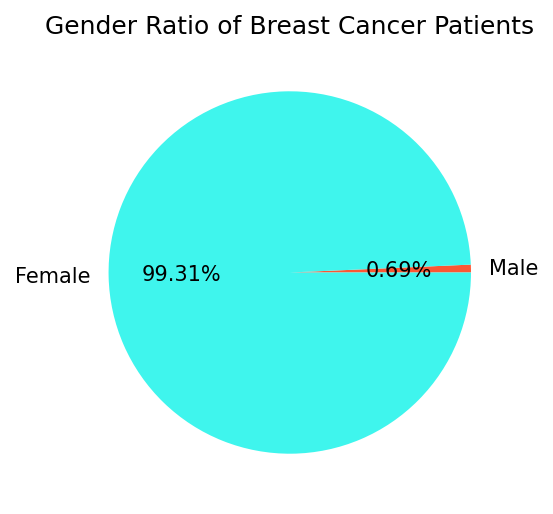

In [ ]:
sql_statement ='''SELECT distinct subject_id,gender
         FROM Breast_cancer'''
cursor.execute(sql_statement)
dbresult = cursor.fetchall()
gender_indicator = []
for r in dbresult:
  #get the gender information
  gender_indicator.append(r[1])

male = gender_indicator.count("M")
female = gender_indicator.count("F")
data=[male, female]
labels = ['Male', 'Female']
colors=["#FB5734", "#3FF5ED"]
name='Gender Ratio of Breast Cancer Patients'
print("With in the data we have {} male patient and {} female patient".format(male,female))
def plot_pie(data,labels,colors,name):
  plt.figure(dpi=150)
  plt.pie(data, labels = labels, colors=colors, autopct = '%1.2f%%')
  plt.title(name)
  plt.show()
plot_pie(data,labels,colors,name)


We notice that there is only 1 male out of 144 patients that is diagnosed with breast cancer. **与世界卫生组织的报告的数据相对比**

## 3.2 Age distribution 

We want to know the age distribution of breast cancer patients (when visiting hospitals, diagnosed, dead) V.S International organization’s recommendation for women health check and breast cancer high-occurrence age.


In [ ]:
get_death_age='''SELECT distinct subject_id, (dod-dob) as expire_age
FROM Breast_cancer
where expire_flag = 1'''
breast_cancer_death_agedata = pd.read_sql(get_death_age, conn)
get_diagnosis_age='''SELECT distinct b.subject_id, (a.admittime-b.dob) as diagnosis_age, JULIANDAY(a.dischtime) - JULIANDAY(a.admittime) as in_hospital_days
FROM Breast_cancer b
inner join Admissions a on a.subject_id == b.subject_id '''
breast_cancer_diagnosis_agedata = pd.read_sql(get_diagnosis_age, conn)
display(breast_cancer_diagnosis_agedata)

,SUBJECT_ID,diagnosis_age,in_hospital_days
0,2297,49,9.718056
1,2693,42,3.024306
2,2984,56,14.736111
3,2984,59,5.186806
4,2984,60,5.465278
...,...,...,...
195,96453,56,1.868750
196,99268,59,4.686806
197,99268,61,7.421528
198,99268,61,10.815278


We notice from below that the largest age of the peolpe who died is 300 which is curently impossible.

In [ ]:
breast_cancer_diagnosis_agedata["diagnosis_age"].describe()

count    200.000000
mean      61.965000
std       32.258749
min       25.000000
25%       48.000000
50%       56.000000
75%       67.000000
max      300.000000
Name: diagnosis_age, dtype: float64

In [ ]:
breast_cancer_diagnosis_agedata["in_hospital_days"].describe()

count    200.000000
mean       8.759226
std        9.196254
min        0.138889
25%        4.151736
50%        5.821528
75%       10.285937
max       85.744444
Name: in_hospital_days, dtype: float64

In [ ]:
breast_cancer_death_agedata['expire_age'].describe()

count     68.000000
mean      67.823529
std       42.948404
min       25.000000
25%       51.000000
50%       59.500000
75%       70.500000
max      301.000000
Name: expire_age, dtype: float64

Therefore, we filter out the data with the age less than 100 and then plot the histogram.

In [ ]:
def plot_histogram(data,name):
  plt.figure(dpi=100)
  plt.hist(data, bins = 12, color = 'steelblue', edgecolor = 'k')
  plt.title(name)
  plt.show()


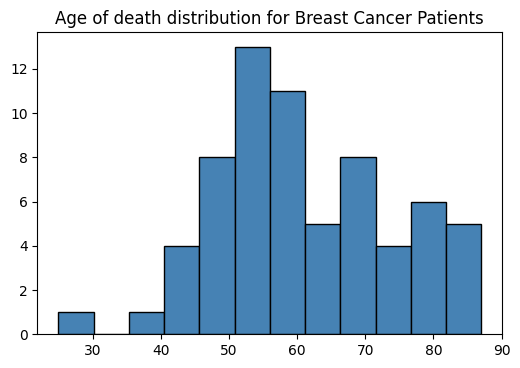

In [ ]:
death_ages=breast_cancer_death_agedata['expire_age']
death_ages=death_ages[death_ages<100]
name='Age of death distribution for Breast Cancer Patients'
plot_histogram(death_ages,name)

we can see that most women who is diagnosed with breast cancer are in age (????)

**与世界卫生组织的报告的数据相对比** 

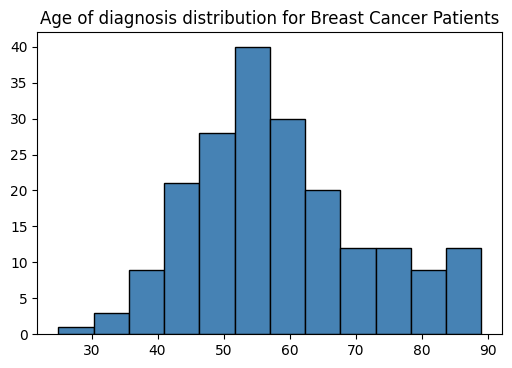

In [ ]:
diagnosis_ages=breast_cancer_diagnosis_agedata['diagnosis_age']
diagnosis_ages=diagnosis_ages[diagnosis_ages<100]
name='Age of diagnosis distribution for Breast Cancer Patients'
plot_histogram(diagnosis_ages,name)

we can see that most women who are diagnosed with breast cancer are in age (?????) **与世界卫生组织的报告的数据相对比**

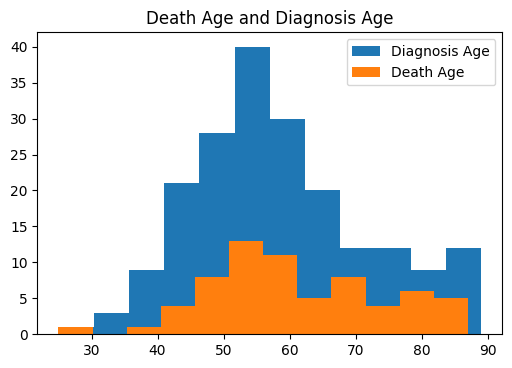

In [ ]:
def plot_2histogram(data1,data2,label1,label2,name):
  plt.figure(dpi=100)
  plt.hist(data2,bins = 12,label=label2)
  plt.hist(data1,bins = 12,label=label1)
  plt.legend()
  plt.title(name)
  plt.show()
label1="Death Age"
label2="Diagnosis Age"
name="Death Age and Diagnosis Age"
plot_2histogram(death_ages,diagnosis_ages,label1,label2,name)  

Then, we want to know the average age of those who died. 

In [ ]:
np.average(death_ages)

**与世界卫生组织的报告的数据相对比, 为啥要看平均死亡年龄来着？** 

## 3.3 Survival ratio (survived V.S dead)

We want to learn about the survival ratio (survived V.S dead) of breast cancer.

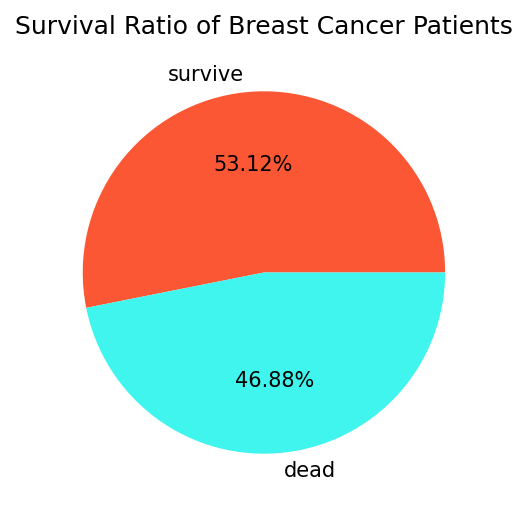

In [ ]:
sql_statement = "SELECT expire_flag FROM Breast_cancer"
cursor.execute(sql_statement)
dbresult = cursor.fetchall()
death_indicator = []
for r in dbresult:
  death_indicator.append(r[0])

# print(death_indicator)
survive = death_indicator.count(0)
death = death_indicator.count(1)
data=[survive, death]
labels = ['survive', 'dead']
colors=["#FB5734", "#3FF5ED"]
name='Survival Ratio of Breast Cancer Patients'
def plot_pie(data,labels,colors,name):
  plt.figure(dpi=150)
  plt.pie(data, labels = labels, colors=colors, autopct = '%1.2f%%')
  plt.title(name)
  plt.show()
plot_pie(data,labels,colors,name)

# 4. Ontology


**Breast cancer Synonyms**

## 4.1 Retrieve DOID terms (and their synonyms) that have ICD9CM codes

The code below (that will be modified by students) iterates through each descendent term of heart disease to extract its DOID, synonyms (including labels), and ICD9 codes that are stored in the corresponding lists. 

In [ ]:
import requests
#  GET (using requests) all the ICD9 terms that are descendants of lung disease as the root
#DOID for lung disease
doid='DOID_1612' #DOID for Breast Cancer
url_base='https://www.ebi.ac.uk/ols/api/ontologies/doid/terms/'
url_terms=url_base+'http%253A%252F%252Fpurl.obolibrary.org%252Fobo%252F'+doid+'/descendants?page=0&size=200'
icdlist = []
doidlist = []
synlist = []
terms={}

# get the JSON output containing all descendants of "heart diseaase"
r2 = requests.get(url = url_terms)
data2 = r2.json()
##insert your own code below to assign the names of the two keys represented by key1 and key2
key1='_embedded'
key2='terms' 

#a collection of terms extracted from the JSON object
terms=data2[key1][key2]

#retrieve DOID's, synonyms (including labels) and ICD9 codes (without dots) for each descendant term
for term in terms:
    # find the database for ICD9 codes
  label=term['label']
  iri=term['iri']
  lst=iri.split('_')
  obo_id='DOID:'+lst[1]
  db=''
  if 'database_cross_reference' in term['annotation']:
    for d2 in term['annotation']['database_cross_reference']:
      dblst=d2.split(':')
      db=dblst[0]
      code=dblst[1]
      if db=='ICD9CM':
        break
    if db=='ICD9CM':
        code=code.replace('.','')
        if 'has_exact_synonym' in term['annotation']:
          doidlist.append(obo_id)
          synlist.append(label)
          icdlist.append(code)
          for s in term['annotation']['has_exact_synonym']:
            doidlist.append(obo_id)
            synlist.append(s)
            icdlist.append(code)

print(f"Length of doidlist: {len(doidlist)}, length of synlist: {len(synlist)}, length of icdlist: {len(icdlist)} \n")  
print(doidlist)

Length of doidlist: 14, length of synlist: 14, length of icdlist: 14 

['DOID:11889', 'DOID:11889', 'DOID:11889', 'DOID:13972', 'DOID:13972', 'DOID:13799', 'DOID:13799', 'DOID:13799', 'DOID:1649', 'DOID:1649', 'DOID:1647', 'DOID:1647', 'DOID:1650', 'DOID:1650']


## 4.2 Create Table that maps DOID with ICD9 

First, we create an empty table. Then we feed the data extracted from [OLS](https://www.ebi.ac.uk/ols/ontologies/doid/terms?iri=http%3A%2F%2Fpurl.obolibrary.org%2Fobo%2FDOID_1612) about Breast Cancer into this mapping table

In [ ]:
cursor.execute("DROP TABLE IF EXISTS DOID_ICD9_mappings")
#insert code to create DOID_ICD9_mappings table
sql ='''CREATE TABLE DOID_ICD9_mappings (
      doid varchar(10),
      synonym varchar(50),
      icd9_code	varchar(10) NULL,
      PRIMARY KEY (doid)
      FOREIGN KEY (icd9_code) REFERENCES d_icd_diagnoses(icd9_code)
  );'''
cursor.execute(sql)

synonyms = None
# load the data from the three lists into a data frame object "synonyms"
data = {'doid':doidlist,'synonym':synlist,'icd9_code':icdlist}
synonyms = pd.DataFrame(data)
# write the data to a sqlite table
synonyms.to_sql('DOID_ICD9_mappings', conn, if_exists='replace', index = False)
# Commit your changes in the database
conn.commit()

We want to see the synonym of the breast cancer.

In [ ]:
sql='''
CREATE TABLE IF NOT EXISTS Breast_cancer_syn AS
  SELECT distinct i.icd9_code, i.short_title,i.long_title,s.doid,s.synonym 
  from D_icd_diagnoses i
  left join DOID_ICD9_mappings s on s.icd9_code==i.icd9_code
  where i.icd9_code IN ("2330", "1740", "1741", "1742", "1743", "1744", "1745", "1746", "1748", "1749");
    '''
cursor.execute(sql)
sql='''
SELECT * from Breast_cancer_syn
'''
syn = pd.read_sql(sql, conn)
pd.set_option('display.max_rows', 100)
display (syn)

,ICD9_CODE,SHORT_TITLE,LONG_TITLE,doid,synonym
0,1740,Malig neo nipple,Malignant neoplasm of nipple and areola of fem...,DOID:11889,female breast nipple and areola cancer
1,1740,Malig neo nipple,Malignant neoplasm of nipple and areola of fem...,DOID:11889,malignant neoplasm of nipple and areola of fem...
2,1740,Malig neo nipple,Malignant neoplasm of nipple and areola of fem...,DOID:11889,malignant neoplasm of nipple or areola of fema...
3,1741,Mal neo breast-central,Malignant neoplasm of central portion of femal...,DOID:13799,female breast central part cancer
4,1741,Mal neo breast-central,Malignant neoplasm of central portion of femal...,DOID:13799,malignant neoplasm of central part of female b...
5,1741,Mal neo breast-central,Malignant neoplasm of central portion of femal...,DOID:13799,malignant neoplasm of central portion of femal...
6,1742,Mal neo breast up-inner,Malignant neoplasm of upper-inner quadrant of ...,DOID:1647,female breast upper-inner quadrant cancer
7,1742,Mal neo breast up-inner,Malignant neoplasm of upper-inner quadrant of ...,DOID:1647,malignant neoplasm of upper-inner quadrant of ...
8,1743,Mal neo breast low-inner,Malignant neoplasm of lower-inner quadrant of ...,DOID:1649,female breast lower-inner quadrant cancer
9,1743,Mal neo breast low-inner,Malignant neoplasm of lower-inner quadrant of ...,DOID:1649,malignant neoplasm of lower-inner quadrant of ...


We can see from above that for ICD9 1744,1748,1749,2330, we do not have corresponding DOID and synonym


**Breast Cancer Drug**

## 4.3 Create Prescription Table

In [ ]:
cursor.execute("DROP TABLE IF EXISTS Prescription")
#insert code to create Prescription table
sql ='''CREATE TABLE Prescription (
      row_id int  NOT NULL,
      subject_id	int NOT NULL,
      hadm_id	int NOT NULL,
      drug_type	varchar(100),
      drug varchar(100),
      drug_name_poe varchar(100),
      FOREIGN KEY (subject_id) REFERENCES patients(subject_id),
      FOREIGN KEY (hadm_id) REFERENCES admissions(hadm_id)
  );'''
cursor.execute(sql)
prescription=pd.read_csv('/content/gdrive/MyDrive/BIS638/2022/PRESCRIPTIONS.csv')
prescription.to_sql('Prescription', conn, if_exists='replace', index = False)

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (11) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
sql='''SELECT distinct p.drug_name_poe
  FROM Prescription p
  inner join Breast_cancer b on p.subject_id=b.subject_id  
  ;'''
breast_cancer_drugs = pd.read_sql(sql, conn)
display(breast_cancer_drugs)

,DRUG_NAME_POE
0,None
1,Fentanyl Patch
2,Venlafaxine XR
3,Lorazepam
4,Femara
...,...
478,Nystatin
479,Nitrofurantoin Monohyd (MacroBID)
480,Torsemide
481,ranolazine


## 4.4 Retrieve data from NCIT 

真TM 难

In [ ]:
import requests
ncit='NCIT_C80067' #DOID for Breast Cancer
url_base='https://www.ebi.ac.uk/ols/ontologies/ncit/terms'
url_terms=url_base+'http%253A%252F%252Fpurl.obolibrary.org%252Fobo%252F'+ncit+'/descendants?page=0&size=200'
print(url_terms)
icdlist = []
doidlist = []
synlist = []
terms={}

# get the JSON output containing all descendants of "heart diseaase"
r2 = requests.get(url = url_terms)
data2 = r2.json()

https://www.ebi.ac.uk/ols/ontologies/ncit/termshttp%253A%252F%252Fpurl.obolibrary.org%252Fobo%252FNCIT_C80067/descendants?page=0&size=200


JSONDecodeError: ignored

# 5. Feature Selection

In [ ]:
#Doping tables if already exists.
cursor.execute("DROP TABLE IF EXISTS ICUSTAYS")
cursor.execute("DROP TABLE IF EXISTS Labevents")

#Creating tables
#insert code to create ICUSTAYS table
sql ='''CREATE TABLE ICUSTAYS (
      row_id int  NOT NULL,
      subject_id	int NOT NULL,
      hadm_id	int NOT NULL,
      icustay_id	int NOT NULL,
      dbsource varchar(20),
      first_careunit varchar(20),
      last_careunit varchar(20),
      first_wardid smallint,
      last_wardid smallint,
      intime timestamp,
      outtime timestamp,
      los float8,
      FOREIGN KEY (subject_id) REFERENCES patients(subject_id),
      FOREIGN KEY (hadm_id) REFERENCES admissions(hadm_id)
  );'''
cursor.execute(sql)

#insert code to create Labevents table
sql ='''CREATE TABLE Labevents (
      row_id int  NOT NULL,
      subject_id	int NOT NULL,
      hadm_id	int NOT NULL,
      itemid	int NULL,
      charttime timestamp,
      value varchar(200),
      valuenum float8,
      valueuom varchar(20),
      flag varchar(20),
      FOREIGN KEY (subject_id) REFERENCES patients(subject_id),
      FOREIGN KEY (hadm_id) REFERENCES admissions(hadm_id)
  );'''
cursor.execute(sql)
print("Table(s) created successfully........")
conn.commit()

#insert code to load ICUSTAYS.csv and Labevents into the corresponding Pandas DataFrame objects
ICUSTAYS = pd.read_csv('/content/gdrive/MyDrive/BIS638/2022/ICUSTAYS.csv')
Labevents = pd.read_csv('/content/gdrive/MyDrive/BIS638/2022/LABEVENTS.csv')

#insert code to write data to ICUSTAYS and Labevents tables
ICUSTAYS.to_sql('ICUSTAYS', conn, if_exists='replace', index = False)
Labevents.to_sql('Labevents', conn, if_exists='replace', index = False)

#Commit your changes in the database
conn.commit()

Table(s) created successfully........


Extract the patients with all the Demographic Information：age, gender

In [ ]:
cursor.execute("DROP TABLE IF EXISTS Dem_info")
Dem_info='''
CREATE TABLE Dem_info AS
  SELECT a.subject_id, hadm_id, 
  (a.admittime-p.dob) 
  AS diagnosis_age,
  (a.dischtime-a.admittime)
  As in_hospital_days,
  insurance,
  marital_status,
  religion,
  ethnicity
  FROM admissions a
  INNER JOIN patients p
  ON a.subject_id = p.subject_id
  '''
cursor.execute(Dem_info)
print("Table(s) created successfully........")
conn.commit()

Table(s) created successfully........


Extract the patients with all the ICU surgery

In [ ]:
cursor.execute("DROP TABLE IF EXISTS ICU_sur")
ICU_sur='''
CREATE TABLE ICU_sur AS
  SELECT hadm_id, 
  sum(los) AS total_icu_time 
  FROM ICUSTAYS
  GROUP BY hadm_id
  '''
cursor.execute(ICU_sur)
print("Table(s) created successfully........")
conn.commit()

Table(s) created successfully........


Extract the patients with all the Lab data

In [ ]:
cursor.execute("DROP TABLE IF EXISTS Lab")
Lab='''
CREATE TABLE Lab AS
  SELECT o.hadm_id, AVG_Urea_nitrogen, STD_Urea_nitrogen, AVG_platelet, STD_platelet, AVG_hematocrito, STD_hematocrito, AVG_potassium, STD_potassium, 
  AVG_sodium, STD_sodium, AVG_creatinine, STD_creatinine, AVG_bicarbonate, STD_bicarbonate, AVG_leukocytes, STD_leukocytes, 
  AVG_sugar, STD_sugar, AVG_albumin, STD_albumin
  FROM
  (SELECT distinct hadm_id
  FROM labevents) o
  left join
  (SELECT hadm_id,
  avg(valuenum) AS AVG_Urea_nitrogen,
  AVG(valuenum*valuenum) - AVG(valuenum)*AVG(valuenum) AS STD_Urea_nitrogen
  FROM labevents
  WHERE itemid = 51066
  GROUP BY hadm_id) a on o.hadm_id=a.hadm_id
  left join
  (SELECT hadm_id,
  avg(valuenum) AS AVG_platelet,
  AVG(valuenum*valuenum) - AVG(valuenum)*AVG(valuenum) AS STD_platelet
  FROM labevents
  WHERE itemid = 51265
  GROUP BY hadm_id) b on o.hadm_id=b.hadm_id
  left join
  (SELECT hadm_id,
  avg(valuenum) AS AVG_hematocrito,
  AVG(valuenum*valuenum) - AVG(valuenum)*AVG(valuenum) AS STD_hematocrito
  FROM labevents
  WHERE itemid = 51221
  GROUP BY hadm_id) c on o.hadm_id=c.hadm_id  
  left join   
  (SELECT hadm_id,
  avg(valuenum) AS AVG_potassium,
  AVG(valuenum*valuenum) - AVG(valuenum)*AVG(valuenum) AS STD_potassium
  FROM labevents
  WHERE itemid = 50971
  GROUP BY hadm_id) d on o.hadm_id=d.hadm_id  
  left join
  (SELECT hadm_id,
  avg(valuenum) AS AVG_sodium,
  AVG(valuenum*valuenum) - AVG(valuenum)*AVG(valuenum) AS STD_sodium
  FROM labevents
  WHERE itemid = 50983
  GROUP BY hadm_id) e on o.hadm_id=e.hadm_id
  left join
  (SELECT hadm_id,
  avg(valuenum) AS AVG_creatinine,
  AVG(valuenum*valuenum) - AVG(valuenum)*AVG(valuenum) AS STD_creatinine
  FROM labevents
  WHERE itemid = 50912
  GROUP BY hadm_id) f on o.hadm_id=f.hadm_id
  left join
  (SELECT hadm_id,
  avg(valuenum) AS AVG_bicarbonate,
  AVG(valuenum*valuenum) - AVG(valuenum)*AVG(valuenum) AS STD_bicarbonate
  FROM labevents
  WHERE itemid = 50882
  GROUP BY hadm_id) j on o.hadm_id=j.hadm_id
  left join
  (SELECT hadm_id,
  avg(valuenum) AS AVG_leukocytes,
  AVG(valuenum*valuenum) - AVG(valuenum)*AVG(valuenum) AS STD_leukocytes
  FROM labevents
  WHERE itemid = 51301
  GROUP BY hadm_id) g on o.hadm_id=g.hadm_id     
  left join
  (SELECT hadm_id,
  avg(valuenum) AS AVG_sugar,
  AVG(valuenum*valuenum) - AVG(valuenum)*AVG(valuenum) AS STD_sugar
  FROM labevents
  WHERE itemid in (50809,50931)
  GROUP BY hadm_id) h on o.hadm_id=h.hadm_id
  left join
  (SELECT hadm_id,
  avg(valuenum) AS AVG_albumin,
  AVG(valuenum*valuenum) - AVG(valuenum)*AVG(valuenum) AS STD_albumin
  FROM labevents
  WHERE itemid = 50862
  GROUP BY hadm_id) i on o.hadm_id=i.hadm_id
  where o.hadm_id is not null        
  '''
cursor.execute(Lab)
print("Table(s) created successfully........")
conn.commit()

Table(s) created successfully........


In [ ]:
cursor.execute("DROP TABLE IF EXISTS data_summary")
data_summary='''
CREATE TABLE data_summary AS
  SELECT *
  FROM icu_sur a
  left join 
  Dem_info b on a.hadm_id=b.hadm_id
  left join 
  Lab c on a.hadm_id=c.hadm_id
  ;'''
cursor.execute(data_summary)
print("Table(s) created successfully........")
conn.commit()

Table(s) created successfully........


In [ ]:
cursor.execute("DROP TABLE IF EXISTS breast_subject_admit")
breast_subject_admit='''
CREATE TABLE breast_subject_admit AS
  SELECT distinct b.expire_flag, a.hadm_id
  FROM Breast_cancer b
  inner join Admissions a on a.subject_id=b.subject_id 
  ;'''
cursor.execute(breast_subject_admit)
print("Table(s) created successfully........")
conn.commit()

Table(s) created successfully........


In [ ]:
cursor.execute("DROP TABLE IF EXISTS breast_summary")
breast_summary='''
CREATE TABLE IF NOT EXISTS breast_summary AS
  SELECT *
  FROM
  (SELECT *,
  case when hadm_id in (select hadm_id from breast_subject_admit) then 1
  else 0
  end as breast_outcome
  FROM data_summary)
  where breast_outcome = 1
  '''
cursor.execute(breast_summary)

In [ ]:
sql='''
  SELECT a.*, b.expire_flag
  FROM breast_summary a
  left join breast_subject_admit b on a.hadm_id=b.hadm_id
  ;'''
data = pd.read_sql(sql, conn)
display(data)

,HADM_ID,total_icu_time,SUBJECT_ID,HADM_ID:1,diagnosis_age,in_hospital_days,INSURANCE,MARITAL_STATUS,RELIGION,ETHNICITY,...,AVG_bicarbonate,STD_bicarbonate,AVG_leukocytes,STD_leukocytes,AVG_sugar,STD_sugar,AVG_albumin,STD_albumin,breast_outcome,EXPIRE_FLAG
0,100247,6.2992,26401,100247,58,1,Private,MARRIED,NOT SPECIFIED,WHITE,...,26.583333,7.409722,17.918182,30.179669,132.476190,792.344671,3.000000,0.000000,1,0
1,100674,3.0695,12268,100674,54,0,Medicaid,SINGLE,UNOBTAINABLE,PATIENT DECLINED TO ANSWER,...,27.000000,0.666667,10.533333,0.648889,149.000000,1592.000000,NaN,NaN,1,0
2,100872,1.8796,18532,100872,36,0,Private,MARRIED,CATHOLIC,WHITE,...,27.500000,0.250000,5.700000,0.090000,117.000000,81.000000,NaN,NaN,1,0
3,101278,1.7066,76782,101278,69,0,Medicare,SINGLE,CATHOLIC,WHITE,...,30.166667,0.472222,12.450000,10.169167,238.142857,2976.693878,2.600000,0.000000,1,1
4,101304,0.8281,18148,101304,48,0,Private,MARRIED,NOT SPECIFIED,WHITE,...,26.125000,5.359375,13.888889,9.149877,123.625000,537.484375,3.100000,0.000000,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,197102,0.5051,99268,197102,59,0,Private,MARRIED,PROTESTANT QUAKER,WHITE,...,23.666667,8.222222,8.066667,3.582222,169.250000,6949.187500,NaN,NaN,1,1
182,197512,5.6627,2984,197512,56,0,Private,MARRIED,CATHOLIC,WHITE,...,25.272727,48.289256,8.185000,12.320275,201.583333,13828.993056,2.566667,0.068889,1,0
183,198590,0.7542,95136,198590,54,0,Private,SINGLE,GREEK ORTHODOX,WHITE,...,26.000000,0.666667,8.066667,0.482222,271.000000,844.666667,NaN,NaN,1,0
184,199170,1.8522,91596,199170,66,0,Private,WIDOWED,CATHOLIC,WHITE,...,24.333333,2.888889,8.916667,5.024722,129.250000,453.187500,NaN,NaN,1,0


In [ ]:
# take out useless columns generated by data table merge
columns = ['SUBJECT_ID','HADM_ID:1','hadm_id:2','HADM_ID','breast_outcome']
data = data.drop(columns, axis=1)
data

,total_icu_time,diagnosis_age,in_hospital_days,INSURANCE,MARITAL_STATUS,RELIGION,ETHNICITY,AVG_Urea_nitrogen,STD_Urea_nitrogen,AVG_platelet,...,STD_creatinine,AVG_bicarbonate,STD_bicarbonate,AVG_leukocytes,STD_leukocytes,AVG_sugar,STD_sugar,AVG_albumin,STD_albumin,EXPIRE_FLAG
0,6.2992,58,1,Private,MARRIED,NOT SPECIFIED,WHITE,None,None,201.583333,...,0.019167,26.583333,7.409722,17.918182,30.179669,132.476190,792.344671,3.000000,0.000000,0
1,3.0695,54,0,Medicaid,SINGLE,UNOBTAINABLE,PATIENT DECLINED TO ANSWER,None,None,211.666667,...,0.006667,27.000000,0.666667,10.533333,0.648889,149.000000,1592.000000,NaN,NaN,0
2,1.8796,36,0,Private,MARRIED,CATHOLIC,WHITE,None,None,156.500000,...,0.002500,27.500000,0.250000,5.700000,0.090000,117.000000,81.000000,NaN,NaN,0
3,1.7066,69,0,Medicare,SINGLE,CATHOLIC,WHITE,None,None,572.666667,...,0.004722,30.166667,0.472222,12.450000,10.169167,238.142857,2976.693878,2.600000,0.000000,1
4,0.8281,48,0,Private,MARRIED,NOT SPECIFIED,WHITE,None,None,443.444444,...,0.007344,26.125000,5.359375,13.888889,9.149877,123.625000,537.484375,3.100000,0.000000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,0.5051,59,0,Private,MARRIED,PROTESTANT QUAKER,WHITE,None,None,198.666667,...,0.002222,23.666667,8.222222,8.066667,3.582222,169.250000,6949.187500,NaN,NaN,1
182,5.6627,56,0,Private,MARRIED,CATHOLIC,WHITE,None,None,109.850000,...,0.023802,25.272727,48.289256,8.185000,12.320275,201.583333,13828.993056,2.566667,0.068889,0
183,0.7542,54,0,Private,SINGLE,GREEK ORTHODOX,WHITE,None,None,231.000000,...,0.006667,26.000000,0.666667,8.066667,0.482222,271.000000,844.666667,NaN,NaN,0
184,1.8522,66,0,Private,WIDOWED,CATHOLIC,WHITE,None,None,266.500000,...,0.005556,24.333333,2.888889,8.916667,5.024722,129.250000,453.187500,NaN,NaN,0


Check NAs

In [ ]:
total = data.isnull().sum().sort_values(ascending=False)
percent = (data.isnull().sum()/data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1,join='outer', keys=['Total Missing Count', '% of Total Observations'])
missing_data.index.name ='Feature'
missing_data.head(20)

,Total Missing Count,% of Total Observations
Feature,,
AVG_Urea_nitrogen,186,1.000000
STD_Urea_nitrogen,186,1.000000
STD_albumin,87,0.467742
AVG_albumin,87,0.467742
STD_potassium,3,0.016129
AVG_potassium,3,0.016129
AVG_bicarbonate,3,0.016129
STD_sodium,3,0.016129
AVG_sodium,3,0.016129


In [ ]:
# retain the columns which have less than 30% missing values
retain_column = missing_data[missing_data['% of Total Observations'] <= 0.3].index.tolist()
data = data[retain_column]
data

,STD_potassium,AVG_potassium,AVG_bicarbonate,STD_sodium,AVG_sodium,STD_bicarbonate,MARITAL_STATUS,AVG_leukocytes,AVG_hematocrito,STD_hematocrito,...,AVG_creatinine,STD_creatinine,STD_platelet,total_icu_time,diagnosis_age,ETHNICITY,RELIGION,INSURANCE,in_hospital_days,EXPIRE_FLAG
0,0.204889,4.366667,26.583333,5.555556,137.333333,7.409722,MARRIED,17.918182,31.366667,6.135556,...,0.950000,0.019167,9080.743056,6.2992,58,WHITE,NOT SPECIFIED,Private,1,0
1,0.062222,4.066667,27.000000,1.555556,137.333333,0.666667,SINGLE,10.533333,32.575000,1.836875,...,0.700000,0.006667,366.222222,3.0695,54,PATIENT DECLINED TO ANSWER,UNOBTAINABLE,Medicaid,0,0
2,0.022500,3.650000,27.500000,0.250000,139.500000,0.250000,MARRIED,5.700000,25.500000,7.440000,...,0.650000,0.002500,56.250000,1.8796,36,WHITE,CATHOLIC,Private,0,0
3,0.036667,4.100000,30.166667,3.583333,139.500000,0.472222,SINGLE,12.450000,28.566667,3.612222,...,0.616667,0.004722,1934.222222,1.7066,69,WHITE,CATHOLIC,Medicare,0,1
4,0.011875,4.175000,26.125000,1.250000,139.500000,5.359375,MARRIED,13.888889,28.546154,4.647101,...,0.862500,0.007344,4290.246914,0.8281,48,WHITE,NOT SPECIFIED,Private,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,0.046667,4.100000,23.666667,4.222222,135.333333,8.222222,MARRIED,8.066667,35.633333,1.082222,...,1.033333,0.002222,141.555556,0.5051,59,WHITE,PROTESTANT QUAKER,Private,0,1
182,0.140351,3.831818,25.272727,7.250000,135.500000,48.289256,MARRIED,8.185000,31.618182,9.977851,...,0.672727,0.023802,864.427500,5.6627,56,WHITE,CATHOLIC,Private,0,0
183,0.166667,3.900000,26.000000,1.555556,138.666667,0.666667,SINGLE,8.066667,37.066667,4.215556,...,0.700000,0.006667,632.000000,0.7542,54,WHITE,GREEK ORTHODOX,Private,0,0
184,0.031389,3.783333,24.333333,4.916667,139.500000,2.888889,WIDOWED,8.916667,36.083333,4.661389,...,0.833333,0.005556,242.250000,1.8522,66,WHITE,CATHOLIC,Private,0,0


In [ ]:
# identity numeric features
numeric_features = data.select_dtypes(include=[np.number])
numeric_features.columns

Index(['STD_potassium', 'AVG_potassium', 'AVG_bicarbonate', 'STD_sodium',
       'AVG_sodium', 'STD_bicarbonate', 'AVG_leukocytes', 'AVG_hematocrito',
       'STD_hematocrito', 'AVG_platelet', 'STD_leukocytes', 'AVG_sugar',
       'STD_sugar', 'AVG_creatinine', 'STD_creatinine', 'STD_platelet',
       'total_icu_time', 'diagnosis_age', 'in_hospital_days', 'EXPIRE_FLAG'],
      dtype='object')

In [ ]:
# identity categorical features
categorical_features = data.select_dtypes(include=[np.object])
categorical_features.columns

<ipython-input-21-178c728cdc75>:2: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  categorical_features = data.select_dtypes(include=[np.object])


Index(['MARITAL_STATUS', 'ETHNICITY', 'RELIGION', 'INSURANCE'], dtype='object')

In [ ]:
# replace missing values of numeric features with mean 
data[numeric_features.columns] = data[numeric_features.columns].fillna(data[numeric_features.columns].mean())

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:3641: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [ ]:
data.MARITAL_STATUS.mode()

0    MARRIED
dtype: object

In [ ]:
# replace missing values of categorical features with mode
data['MARITAL_STATUS'] = data['MARITAL_STATUS'].fillna('MARRIED')

<ipython-input-24-e12a923019d6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['MARITAL_STATUS'] = data['MARITAL_STATUS'].fillna('MARRIED')


Transform categorical variables into dummy variables

In [ ]:
data = pd.get_dummies(data)
data

,STD_potassium,AVG_potassium,AVG_bicarbonate,STD_sodium,AVG_sodium,STD_bicarbonate,AVG_leukocytes,AVG_hematocrito,STD_hematocrito,AVG_platelet,...,RELIGION_JEWISH,RELIGION_NOT SPECIFIED,RELIGION_OTHER,RELIGION_PROTESTANT QUAKER,RELIGION_UNITARIAN-UNIVERSALIST,RELIGION_UNOBTAINABLE,INSURANCE_Government,INSURANCE_Medicaid,INSURANCE_Medicare,INSURANCE_Private
0,0.204889,4.366667,26.583333,5.555556,137.333333,7.409722,17.918182,31.366667,6.135556,201.583333,...,0,1,0,0,0,0,0,0,0,1
1,0.062222,4.066667,27.000000,1.555556,137.333333,0.666667,10.533333,32.575000,1.836875,211.666667,...,0,0,0,0,0,1,0,1,0,0
2,0.022500,3.650000,27.500000,0.250000,139.500000,0.250000,5.700000,25.500000,7.440000,156.500000,...,0,0,0,0,0,0,0,0,0,1
3,0.036667,4.100000,30.166667,3.583333,139.500000,0.472222,12.450000,28.566667,3.612222,572.666667,...,0,0,0,0,0,0,0,0,1,0
4,0.011875,4.175000,26.125000,1.250000,139.500000,5.359375,13.888889,28.546154,4.647101,443.444444,...,0,1,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,0.046667,4.100000,23.666667,4.222222,135.333333,8.222222,8.066667,35.633333,1.082222,198.666667,...,0,0,0,1,0,0,0,0,0,1
182,0.140351,3.831818,25.272727,7.250000,135.500000,48.289256,8.185000,31.618182,9.977851,109.850000,...,0,0,0,0,0,0,0,0,0,1
183,0.166667,3.900000,26.000000,1.555556,138.666667,0.666667,8.066667,37.066667,4.215556,231.000000,...,0,0,0,0,0,0,0,0,0,1
184,0.031389,3.783333,24.333333,4.916667,139.500000,2.888889,8.916667,36.083333,4.661389,266.500000,...,0,0,0,0,0,0,0,0,0,1


Train test spliting

In [ ]:
target = 'EXPIRE_FLAG'
X = data.drop(target, axis=1)
y = data[target]

In [ ]:
from sklearn.model_selection import train_test_split
X_train,X_test, y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=13)

Random Forest Training

In [ ]:
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train,y_train)

RandomForestRegressor(random_state=0)

Show the Top 5 important variables

<Figure size 900x600 with 0 Axes>

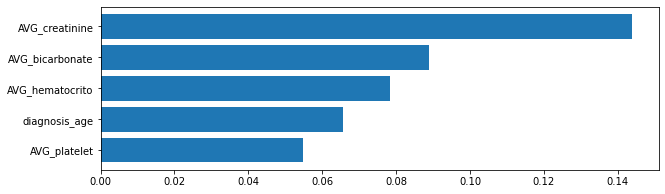

In [ ]:
features = X_train.columns
plt.figure(dpi=150)
plt.figure(figsize=(10,3))
f_i = list(zip(features,rf.feature_importances_))
f_i.sort(key = lambda x : x[1])
plt.barh([x[0] for x in f_i[-5:]],[x[1] for x in f_i[-5:]])

plt.show()

So from the above diagram, we can conclude that the most important features are AVG_leukocytes, AVG_platelet, total_icu_time, AVG_sodium, AVG_potassium and diagnosis_age.

In [ ]:
# choose 75% quantile as the threshold
quantile_75 = np.quantile(rf.feature_importances_,q=0.75,interpolation='linear')

In [ ]:
# extract important features to decrease feature space dimensions
X_train = X_train[features[rf.feature_importances_>quantile_75]]
X_test = X_test[features[rf.feature_importances_>quantile_75]]

In [ ]:
X_train

,STD_potassium,AVG_bicarbonate,AVG_sodium,AVG_leukocytes,AVG_hematocrito,STD_hematocrito,AVG_platelet,AVG_sugar,STD_sugar,AVG_creatinine,STD_platelet,total_icu_time,diagnosis_age
19,0.029600,26.600000,136.000000,7.080000,21.887500,2.588594,249.200000,121.200000,1456.160000,0.360000,2218.960000,2.8144,37
17,0.074400,18.800000,143.600000,4.380000,28.620000,3.085600,235.400000,97.500000,274.750000,0.400000,292.240000,1.0030,60
94,0.046875,29.000000,139.800000,8.720000,28.566667,1.738889,168.571429,138.333333,576.888889,0.540000,849.673469,2.3344,55
51,0.000000,24.000000,140.000000,12.500000,35.300000,0.000000,278.000000,205.500000,156.250000,0.500000,0.000000,1.1347,68
124,0.326746,23.750000,140.750000,26.645455,29.076923,4.144852,182.181818,110.833333,407.305556,0.683333,787.421488,5.1516,49
...,...,...,...,...,...,...,...,...,...,...,...,...,...
98,0.021875,23.000000,134.500000,6.175000,28.125000,0.036875,240.500000,97.750000,63.187500,0.525000,655.250000,2.0025,83
16,0.068889,24.666667,136.666667,11.040000,26.160000,2.206400,254.000000,114.750000,95.687500,0.566667,569.200000,2.1138,33
74,0.098056,25.727273,137.363636,8.500000,28.519048,13.378685,390.692308,99.416667,52.409722,0.618182,4571.289941,6.5196,47
176,0.109592,23.928571,141.214286,16.685714,36.914286,32.891224,184.142857,221.294118,1708.089965,0.650000,2267.122449,3.1184,70


# 6. Logistic Regression

It is significant to train a model to predict whether a person can get breast cancer so that we can prevent the disease easier. 

In [ ]:
# median of ICU Stay
np.median(X.total_icu_time)

1.9135499999999999

In [ ]:
# mean of ICU Stay
np.mean(X.total_icu_time)

3.324759677419354

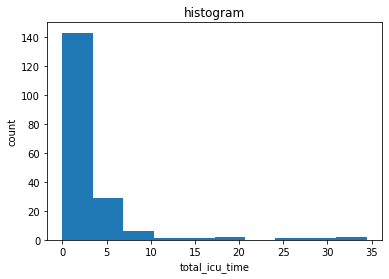

In [ ]:
# histograms for patient age at visit
plt.hist(X.total_icu_time)
plt.title("histogram")
plt.xlabel("total_icu_time")
plt.ylabel("count")
plt.show()

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


<Figure size 900x600 with 0 Axes>

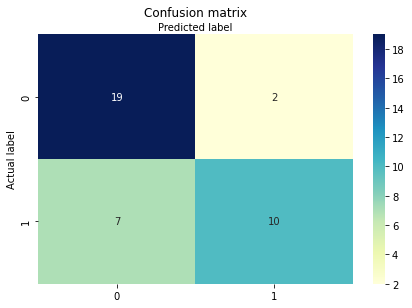

In [ ]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(random_state=16)
logreg.fit(X_train, y_train)
y_pred = logreg.predict(X_test)


from sklearn import metrics

cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cnf_matrix

# import required modules
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
def plot_confusion_matrix(cnf_matrix):
  class_names=[0,1] # name  of classes
  plt.figure(dpi=150)
  fig, ax = plt.subplots()
  tick_marks = np.arange(len(class_names))
  plt.xticks(tick_marks, class_names)
  plt.yticks(tick_marks, class_names)
  # create heatmap
  sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
  ax.xaxis.set_label_position("top")
  plt.tight_layout()
  plt.title('Confusion matrix', y=1.1)
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  
plot_confusion_matrix(cnf_matrix)

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_logistic_regression = accuracy_score(y_test,y_pred)
print("Accuracy of testing dataset: %.2f%%" % (accuracy_logistic_regression * 100.0))

NameError: ignored

<Figure size 900x600 with 0 Axes>

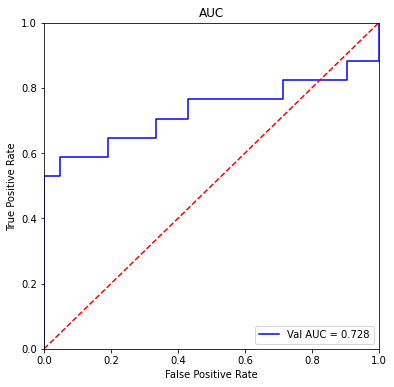

In [ ]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import pylab as plt
pred = logreg.predict_proba(X_test)[:,1]
fpr, tpr, threshold = metrics.roc_curve(y_test, pred)
roc_auc = metrics.auc(fpr, tpr)
plt.figure(dpi=150)
plt.figure(figsize=(6,6))
plt.title('AUC')
plt.plot(fpr, tpr, 'b', label = 'Val AUC = %0.3f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

**如果是比较神经网络与RF的话，是不是我们也做一个confusion matrix 比较好呢？**

# End the connection at the end of the document

In [ ]:
if conn:
  conn.close()

# 7. Reference & Acknowlegement

- Johnson, A., Pollard, T., & Mark, R. (2016). MIMIC-III Clinical Database (version 1.4). PhysioNet. https://doi.org/10.13026/C2XW26.

- Johnson, A. E. W., Pollard, T. J., Shen, L., Lehman, L. H., Feng, M., Ghassemi, M., Moody, B., Szolovits, P., Celi, L. A., & Mark, R. G. (2016). MIMIC-III, a freely accessible critical care database. Scientific Data, 3, 160035.

- Goldberger, A., Amaral, L., Glass, L., Hausdorff, J., Ivanov, P. C., Mark, R., ... & Stanley, H. E. (2000). PhysioBank, PhysioToolkit, and PhysioNet: Components of a new research resource for complex physiologic signals. Circulation [Online]. 101 (23), pp. e215–e220.

- https://github.com/yijunyang/database/blob/main/MIMIC3_Project.ipynb

- Thanks to instructors Kei-Hoi Cheung, Ph.D. (Kei.cheung@yale.edu) and Ronald "George" Hauser, M.D. (ronald.hauser@yale.edu) for providing this informative course. Also, thanks to our teaching fellow Han Yu (han.yu@yale.edu) for providing advices on this project.
